purpose: identify rat and human only subnetworks networks for the loco-ext network and compare to the BMI paper's combined species-enriched approach.

# set-up

Note: functions are at bottom of notebook- run first

In [1]:
import os
import pandas as pd
import ndex2
import networkx as nx
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
import sys
import random

In [2]:
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
from rca_functions import *

In [3]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [4]:
random_seed=random.seed(211)

In [5]:
save_fig=False

In [6]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


In [7]:
IBM=['#648FFF','#785EF0','#DC267F','#FE6100','#FFB000']
colour_dict={
    'ext':IBM[1],
    'ext_alt':IBM[0],
    'ext_munged':IBM[1],
    'ext_munged_alt':IBM[0],
    'loco':IBM[4],
    'loco_alt':IBM[3],
    'shared':IBM[2],
    'other':'#CCCCCC',
    'shared_alt':'#780534'
}

In [8]:
UUIDs={
    'PCNet2.0':'d73d6357-e87b-11ee-9621-005056ae23aa',
    'PCNet2.1':'e9c574f4-e87a-11ee-9621-005056ae23aa',
    'PCNet2.2':'8b4b54fa-e87d-11ee-9621-005056ae23aa'
}

In [9]:
plt.rcParams.update({'font.size': 16})

# functions

In [10]:
def import_seedgenes(path,pcol='P',gene_col='GENE NAME',delim='comma', cutoff=None):
    if delim=='comma':
        df=pd.read_csv(path,sep=',')
    else:
        df=pd.read_csv(path,sep='\t')
    if pcol==None:
        print('pvalue column not specified- all genes will be used')
        cutoff=None
    if cutoff=='bonferroni':
        df=df[df[pcol]<0.05/len(df)]
    elif cutoff=='FDR_05':
        df=df[df[pcol]<0.05]
    else:
        print('cutoff not defined/custom- using all genes ')
        df=df
    print(df.head())
    return(df)

In [11]:
def import_interactome(interactome_name=None, UUIDs=UUIDs,ndex_user=None, ndex_password=None,UUID=None):
    """
    Imports a gene interactome from the NDEx database and returns it as a NetworkX graph object. Optionally,
    the function allows for importing using a unique identifier (UUID) or by an interactome name.

    The function checks if the interactome name provided corresponds to a predefined dictionary of UUIDs. If it does, it
    retrieves the network using the specified credentials. If an interactome name is not provided but a UUID is,
    it retrieves the network using the provided UUID. The nodes of pcnet_v14 are relabelled by their gene name rather than ID number.

    Parameters:
    - interactome_name (str, optional): The name of the interactome as defined in the UUIDs dictionary. If not provided
      but a UUID is, the interactome associated with the UUID is imported instead.
    - ndex_user (str, optional): The NDEx account username for accessing private networks.
    - ndex_password (str, optional): The NDEx account password for accessing private networks.
    - UUID (str, optional): A specific UUID to directly download an interactome from NDEx if the interactome name is not used.

    Returns:
    networkx.Graph: A graph object representing the interactome. Nodes and edges represent genes and their interactions, respectively.

    Notes:
    - The function uses the NDEx2 Python client and requires Internet access to NDEx's servers.
    - Depending on the access rights of the NDEx account, private or public interactomes can be retrieved.
    - The function prints the number of nodes and edges of the imported graph for diagnostic purposes.

    Raises:
    - ValueError: If neither an interactome name nor a UUID is provided.
    """    
    interactome_uuid=UUIDs[interactome_name]
    print(interactome_name)
    ndex_server='public.ndexbio.org'
    #import network based on provided interactome key
    if (interactome_name in UUIDs.keys()):
        graph = ndex2.create_nice_cx_from_server(
                    ndex_server, 
                    username=ndex_user, 
                    password=ndex_password, 
                    uuid=interactome_uuid
                ).to_networkx()
        if (interactome_name=='pcnet_v14'):
            graph=nx.relabel_nodes(graph, nx.get_node_attributes(graph, 'HGNC Symbol'))
        # print out interactome num nodes and edges for diagnostic purposes
        print('number of nodes:')
        print(len(graph.nodes))
        print('\nnumber of edges:')
        print(len(graph.edges))
        return(graph)
    elif(interactome_name==None & UUID!=None):
        print('using novel UUID. For UUIDs used in this study, see UUID_dict')
        graph = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=UUID
        ).to_networkx()
        # print out interactome num nodes and edges for diagnostic purposes
        print('number of nodes:')
        print(len(graph.nodes))
        print('\nnumber of edges:')
        print(len(graph.edges))
        return(graph)
    else:
        print('UUID/interactome name not provided- please provide either to import interactome.')

In [12]:
def plt_scatter_NPS(tblr, tblc, tblr_label, tblc_label, tblr_seed, tblc_seed,
                    colour_r=colour_dict['loco'], colour_c=colour_dict['ext'], colour_shared=colour_dict['shared'],colour_nonseed=colour_dict['shared'],
                    tblr_lim=1.5, tblc_lim=1.5, comb_lim=3, savefig=False, filename='scatter_NPS'):
    """
    Visualizes the NPScommon and NPSrare scores as a scatter plot with and without seed genes

    The function generates four plots in a single figure: two histograms of NPScommon and NPS rare with and without seed genes,
    a combined histogram of NPScommon-rare, and a scatter plot of combined scores with network threshold lines,
    where NPSrare is plotted on the x-axis and NPScommon is plotted on the y-axis.

    Parameters:
    - tblr (DataFrame): DataFrame containing NPSrare.
    - tblc (DataFrame): DataFrame containing NPScommon.
    - tblr_label (str): Label for rare trait, used in the Venn diagram.
    - tblc_label (str): Label for common trait, used in the Venn diagram.
    - tblr_seed (list of str): A list of rare seed genes.
    - tblc_seed (list of str): A list of common seed genes.
    - tblr_lim (float, optional): The NPSrare cutoff. Defaults to 1.5.
    - tblc_lim (float, optional): The NPScommon cutoff. Defaults to 1.5.
    - comb_lim (float, optional): The NPScommon-rare. Defaults to 3.
    - savefig (bool, optional): If True, saves the plot as an SVG file in a predefined directory. Defaults to False.

    Returns:
    None
    """
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12.5, 5))

    # Combine zscore tables
    tbl_z = pd.concat([tblr, tblc], axis=1)
    tbl_z.columns = ('z1', 'z2')
    tbl_z['z_comb'] = tbl_z['z1'] * tbl_z['z2']

    # Separate in-network and out-network data
    inNetwork = tbl_z[(tbl_z['z1'] > tblr_lim) & (tbl_z['z2'] > tblc_lim) & (tbl_z['z_comb'] > comb_lim)]
    outNetwork = tbl_z[(tbl_z['z1'] <= tblr_lim) | (tbl_z['z2'] <= tblc_lim) | (tbl_z['z_comb'] <= comb_lim)]
    seedInNetwork = inNetwork[(~inNetwork.index.isin(tblr_seed)) & (~inNetwork.index.isin(tblc_seed))]

    # Plot with seed genes
    ax1.scatter(x=outNetwork['z1'], y=outNetwork['z2'], s=1, color=color_dict['other'],label='non-network genes')
    ax1.scatter(x=inNetwork['z1'], y=inNetwork['z2'], s=1, color=colour_nonseed,label='network seed genes')
    ax1.scatter(x=seedInNetwork['z1'], y=seedInNetwork['z2'], s=1, color=colour_shared,label='network genes')


    # Set labels and lines for ax1
    ax1.set_xlabel(tblr_label)
    ax1.set_ylabel(tblc_label)
    ax1.axvline(x=tblr_lim, color=colour_r, linestyle='dashed', linewidth=1,label='NPSr')
    ax1.axhline(y=tblc_lim, color=colour_c, linestyle='dashed', linewidth=1,label='NPSh')
    x_points = [(i + 0.0001) / 10 for i in range(-50, 250)]
    combo_line = [comb_lim / x for x in x_points if x > comb_lim / 50]
    ax1.plot([x for x in x_points if x > comb_lim / 40], combo_line, color=colour_shared, linestyle='dashed', linewidth=1,label='NPSrh')
    ax1.axvline(x=0, color='black', linestyle='solid', linewidth=1)
    ax1.axhline(y=0, color='black', linestyle='solid', linewidth=1)
    ax1.legend(loc='center right', bbox_to_anchor=(2.75, 0.5))

    
    # Filter out seed genes
    tbl_z = tbl_z[(~tbl_z.index.isin(tblr_seed)) & (~tbl_z.index.isin(tblc_seed))]
    inNetwork = tbl_z[(tbl_z['z1'] > tblr_lim) & (tbl_z['z2'] > tblc_lim) & (tbl_z['z_comb'] > comb_lim)]
    outNetwork = tbl_z[(tbl_z['z1'] <= tblr_lim) | (tbl_z['z2'] <= tblc_lim) | (tbl_z['z_comb'] <= comb_lim)]

    # Plot without seed genes
    ax2.scatter(x=outNetwork['z1'], y=outNetwork['z2'], s=1, color=color_dict['other'])
    ax2.scatter(x=inNetwork['z1'], y=inNetwork['z2'], s=1, color=colour_shared)

    # Set labels and lines for ax2
    ax2.set_xlabel(tblr_label)
    ax2.set_ylabel(tblc_label)
    ax2.axvline(x=tblr_lim, color=colour_r, linestyle='dashed', linewidth=1)
    ax2.axhline(y=tblc_lim, color=colour_c, linestyle='dashed', linewidth=1)
    x_points = [(i + 0.0001) / 10 for i in range(-50, 250)]
    combo_line = [comb_lim / x for x in x_points if x > comb_lim / 50]
    ax2.plot([x for x in x_points if x > comb_lim / 40], combo_line, color=colour_shared, linestyle='dashed', linewidth=1)
    ax2.axvline(x=0, color='black', linestyle='solid', linewidth=1)
    ax2.axhline(y=0, color='black', linestyle='solid', linewidth=1)
    ax2.set_xlim([min(tbl_z['z1'])-.5, max(tbl_z['z1'])+.5])
    ax2.set_ylim([min(tbl_z['z2'])-.5, max(tbl_z['z2'])+.5])

    # Save the figure if requested
    if savefig:
        plt.savefig('figures/' + filename + '.svg', bbox_inches='tight')

    # Display the plot
    plt.show()


In [13]:
#straight from BMI network notebook 3

def sub_graph(data, rat_th_dict, human_th_dict, conserved_th_dict):
    """Wrapper function to assign each gene in data to a subnetwork based on the thresholds defined

    Args:
        data (pandas.DataFrame): DataFrame containing the genes and their NPS scores
        rat_th_dict (dict): A dictionary specifying the three thresholds to define the rat-Specific network
        human_th_dict (dict): A dictionary specifying the three thresholds to define the human-Specific network
        conserved_th_dict (dict): A dictionary specifying the three thresholds to define the conserved network

    Returns:
        pandas.DataFrame: The input data set with a new/updated subgraph column for all subnetworks
    """
    if "subgraph" not in data.columns:
        data = data.assign(subgraph="PCNet")
    else:
        data["subgraph"] = "PCNet"
    data = assign_sub_graph(data, th_dict = conserved_th_dict, name="conserved")
    data = assign_sub_graph(data, th_dict = rat_th_dict, name="rat")
    data = assign_sub_graph(data, th_dict = human_th_dict, name="human")
    return data

def assign_sub_graph(data, rat_th=None, human_th=None, combo_th=None, th_dict=None, name="conserved"):
    """Assigns sub_graph annotations based on input thresholds

    Args:
        data (pd.DataFrame): Dataframe containing the NPS scores for all genes
        rat_th (dict, optional): If assigning the rat-Specific network, rat-Specific thresholds. Defaults to None.
        human_th (dict, optional): If assigning the human-Specific network, human-Specific thresholds. Defaults to None.
        combo_th (dict, optional): If assigning the conserved network, conserved thresholds. Defaults to None.
        th_dict (dict, optional): Dictionary of all thresholds.  Defaults to None.
        name (str, optional): Name of the subgraph being assigned. Defaults to "conserved".

    Returns:
        pandas.DataFrame: The input data set with a new/updated subgraph column for a single subnetwork
    """
    if th_dict is not None:
        rat_th = th_dict["rat"]
        combo_th = th_dict["combo"]
        human_th = th_dict["human"]
    if "subgraph" not in data.columns:
        data = data.assign(subgraph="PCNet")
    if name == "rat":
        data.loc[((data.NPS_r > rat_th) & (data.NPS_h < human_th) & (data.NPS_r * (data.NPS_h - 1) < combo_th)), 
                ("subgraph")] = "Rat-Specific"
    elif name == "human":
        data.loc[((data.NPS_r < rat_th) & (data.NPS_h > human_th) & ((data.NPS_r - 1)*(data.NPS_h) < combo_th)), 
                ("subgraph")] = "Human-Specific"
    else:
        data.loc[((data.NPS_r > rat_th) & (data.NPS_h > human_th) & (data.NPS_hr > combo_th)), ("subgraph")] = "Conserved"
    return data

# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [14]:
interactome_name='PCNet2.0'

In [15]:
graph=import_interactome('PCNet2.0')

PCNet2.0
number of nodes:
19267

number of edges:
3852119


In [16]:
all_nodes=list(graph.nodes())

In [17]:
# pre calculate the matricies used for network propagation
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(graph, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)


calculating w_prime

calculating w_double_prime


# import NPS scores and seed genes

In [18]:
mag_dir='magma/seed_genes/'
file_dict={
    'loco':mag_dir+'loco_win10_annot.tsv',
    'loco_gsem':mag_dir+'loco_gsem_annot.tsv',
    'ext_munged':mag_dir+'ext_munged_annot.tsv',
    'ext':mag_dir+'ext_orig_annot.tsv'
}

In [19]:
seed_dict={}

In [20]:
loco=pd.read_csv(file_dict['loco'],sep='\t')
loco_bonf_cut=2.6389402016150313e-06 #calculated in define_seed_genes_orthologs- from raw magma results before adding in ortholog info
seed_dict['loco_FDR']=(set(loco[loco['Q']<0.05]['HM_ORTHO']))
seed_dict['loco_bonf']=(set(loco[loco['P']<loco_bonf_cut]['HM_ORTHO']))

In [21]:
#locomotor- gsem common factor
loco_gsem=pd.read_csv(file_dict['loco_gsem'],sep='\t')
loco_gsem_bonf_cut=2.650129856362962e-06 #calculated in define_seed_genes_orthologs- from raw magma results before adding in ortholog info
seed_dict['loco_gsem_FDR']=(set(loco_gsem[loco_gsem['Q']<0.05]['HM_ORTHO']))
seed_dict['loco_gsem_bonf']=(set(loco_gsem[loco_gsem['P']<loco_gsem_bonf_cut]['HM_ORTHO']))

In [22]:
ext=pd.read_csv(file_dict['ext'],sep='\t')
ext_bonf_cut=0.05/len(ext) # no ortholog adding, so can calculate from this table
seed_dict['ext_FDR']=(set(ext[ext['Q']<0.05]['GENE']))
seed_dict['ext_bonf']=(set(ext[ext['P']<ext_bonf_cut]['GENE']))
seed_dict['ext_top500']=set(ext[(ext['GENE'].isin(all_nodes))].nsmallest(500,'P')['GENE'])
seed_dict['ext_subsample']=(set(ext[ext['P']<ext_bonf_cut]['GENE']))


In [23]:
NPS_dict={}
for k in seed_dict.keys():
    for u in UUIDs.keys():
        p=('network_scores/'+k+'_'+u+'_zscore.tsv')
        if os.path.isfile(p):
            t=pd.read_csv('network_scores/'+k+'_'+u+'_zscore.tsv',header=None, sep='\t')
            t.index=t[0]
            t=t.drop(columns=[0])
            t=t[1].squeeze()
            t = pd.DataFrame({'z':t})
            NPS_dict[k+'_'+u]=t

In [24]:
NPS_dict_series={}
for k in seed_dict.keys():
    for u in UUIDs.keys():
        p=('network_scores/'+k+'_'+u+'_zscore.tsv')
        if os.path.isfile(p):
            t=pd.read_csv('network_scores/'+k+'_'+u+'_zscore.tsv',header=None, sep='\t')
            t.index=t[0]
            t=t.drop(columns=[0])
            #t=t[1].squeeze()
            #t = pd.DataFrame({'z':t})
            NPS_dict_series[k+'_'+u]=t

In [25]:
NPS_dict.keys()

dict_keys(['loco_FDR_PCNet2.0', 'loco_FDR_PCNet2.2', 'loco_bonf_PCNet2.0', 'loco_bonf_PCNet2.2', 'loco_gsem_FDR_PCNet2.0', 'loco_gsem_FDR_PCNet2.1', 'loco_gsem_FDR_PCNet2.2', 'loco_gsem_bonf_PCNet2.0', 'loco_gsem_bonf_PCNet2.1', 'loco_gsem_bonf_PCNet2.2', 'ext_FDR_PCNet2.0', 'ext_FDR_PCNet2.2', 'ext_bonf_PCNet2.0', 'ext_bonf_PCNet2.2', 'ext_top500_PCNet2.0', 'ext_subsample_PCNet2.0'])

# choose datasets for analysis

In [26]:
cut_r= 'FDR'
cut_h='top500'
trait_r='loco_gsem'
trait_h='ext'

#labels
label_r=trait_r+'_'+cut_r
label_h=trait_h+'_'+cut_h
#seed genes
seed_r=seed_dict[label_r]
seed_h=seed_dict[label_h]
#NPS scores
NPS_r=NPS_dict[label_r+'_'+interactome_name]
NPS_h=NPS_dict[label_h+'_'+interactome_name]

In [27]:
tbl_z = pd.concat([NPS_r, NPS_h], axis=1)
tbl_z.columns = ('NPS_r', 'NPS_h')
tbl_z['NPS_hr'] = tbl_z['NPS_r'] * tbl_z['NPS_h']

In [28]:
tbl_z['NPS_h'].describe()

count    19265.000000
mean         0.211768
std          2.417599
min         -4.206487
25%         -0.872553
50%         -0.229565
75%          0.661548
max         33.709372
Name: NPS_h, dtype: float64

In [29]:
tbl_z['NPS_r'].describe()

count    19265.000000
mean         0.225086
std          2.448488
min         -5.392147
25%         -0.810858
50%         -0.152763
75%          0.709950
max         37.114705
Name: NPS_r, dtype: float64

In [30]:
tbl_z['NPS_hr'].describe()

count    19265.000000
mean         0.357447
std         10.225488
min        -62.853660
25%         -0.440225
50%          0.032056
75%          0.592802
max        775.295470
Name: NPS_hr, dtype: float64

# subset table for graphing

In [31]:
single_cut_coloc=1.5
comb_cut_coloc=3

In [32]:
#subset table for just those inside and outside of the colocalized network
outNetwork = tbl_z[(tbl_z['NPS_r'] <= single_cut_coloc) | (tbl_z['NPS_h'] <= single_cut_coloc) | (tbl_z['NPS_hr'] <= comb_cut_coloc)]
inNetwork = tbl_z[(tbl_z['NPS_r'] > single_cut_coloc) & (tbl_z['NPS_h'] > single_cut_coloc) & (tbl_z['NPS_hr'] > comb_cut_coloc)]
seeds_r=tbl_z.filter(items=list(seed_r), axis=0)
seeds_h=tbl_z.filter(items=list(seed_h), axis=0)
seeds_hr=tbl_z.filter(items=list(set(seed_r).intersection(seed_h)), axis=0)

# define rat-only network

In [80]:
#rat_only=outNetwork[(outNetwork['NPS_r'] > 3) & (outNetwork['NPS_h'] < 1.5)]
rat_only=tbl_z[(tbl_z['NPS_r'] > 3) & (tbl_z['NPS_h'] < 0) &(tbl_z['NPS_hr']<0) ]

In [65]:
#rat_only=outNetwork[(outNetwork['NPS_r'] > 3) & (outNetwork['NPS_h'] < 1.5)]
rat_only=tbl_z[(tbl_z['NPS_r'] > 3) & (tbl_z['NPS_h'] < 0) &(tbl_z['NPS_hr']<0) ]

In [81]:
rat_only['NPS_h'].describe()

count    360.000000
mean      -0.873254
std        0.628359
min       -3.801426
25%       -1.215011
50%       -0.799476
75%       -0.409089
max       -0.005654
Name: NPS_h, dtype: float64

(array([ 3.,  0.,  5.,  1., 10., 24., 62., 84., 84., 87.]),
 array([-3.80142598, -3.42184877, -3.04227156, -2.66269435, -2.28311713,
        -1.90353992, -1.52396271, -1.1443855 , -0.76480829, -0.38523107,
        -0.00565386]),
 <BarContainer object of 10 artists>)

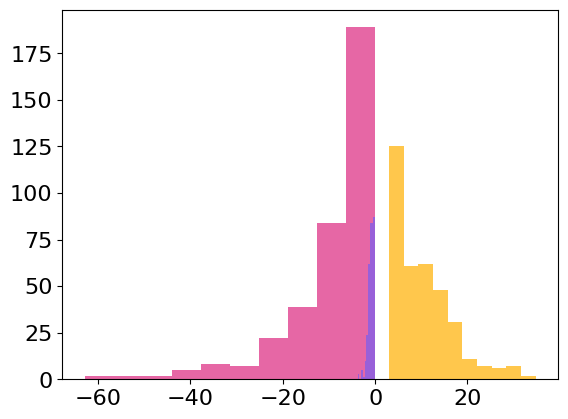

In [67]:
plt.hist(rat_only['NPS_hr'],alpha=0.7, color=colour_dict['shared'])
plt.hist(rat_only['NPS_r'],alpha=0.7, color=colour_dict['loco'])
plt.hist(rat_only['NPS_h'],alpha=0.7, color=colour_dict['ext'])

In [68]:
print("number of human seed genes in rat-only network: "+str(len(rat_only.filter(items=list(seed_h), axis=0))))

number of human seed genes in rat-only network: 0


In [69]:
print("portion of of rat seed genes in human-only network: "+str(len(rat_only.filter(items=list(seed_r), axis=0))/len(rat_only)))

portion of of rat seed genes in human-only network: 0.6972222222222222


# define human only

In [70]:
#hm_only=outNetwork[(outNetwork['NPS_h'] > 3) & (outNetwork['NPS_r'] < 1.5)]
hm_only=tbl_z[(tbl_z['NPS_h'] > 3) & (tbl_z['NPS_r'] < 0)&(tbl_z['NPS_hr']<0) ]

In [71]:
hm_only['NPS_r'].describe()

count    368.000000
mean      -0.767409
std        0.575924
min       -4.009368
25%       -1.023645
50%       -0.657964
75%       -0.358243
max       -0.000671
Name: NPS_r, dtype: float64

(array([117.,  73.,  71.,  49.,  24.,  12.,  11.,   8.,   1.,   2.]),
 array([ 3.0163025 ,  5.96696025,  8.917618  , 11.86827574, 14.81893349,
        17.76959124, 20.72024899, 23.67090674, 26.62156449, 29.57222224,
        32.52287998]),
 <BarContainer object of 10 artists>)

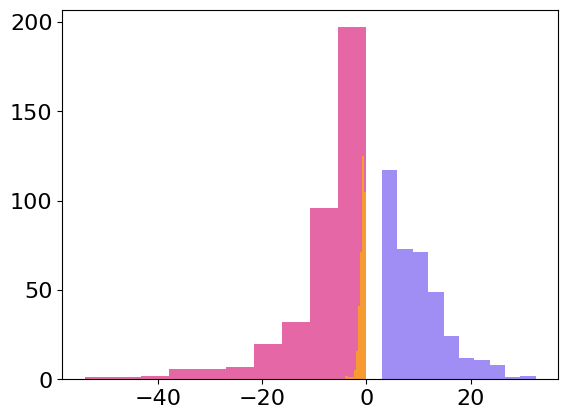

In [72]:
plt.hist(hm_only['NPS_hr'],alpha=0.7, color=colour_dict['shared'])
plt.hist(hm_only['NPS_r'],alpha=0.7, color=colour_dict['loco'])
plt.hist(hm_only['NPS_h'],alpha=0.7, color=colour_dict['ext'])

In [73]:
print("number of rat seed genes in human-only network: "+str(len(hm_only.filter(items=list(seed_r), axis=0))))

number of rat seed genes in human-only network: 0


In [74]:
print("portion of of human seed genes in human-only network: "+str(len(hm_only.filter(items=list(seed_h), axis=0))/len(hm_only)))

portion of of human seed genes in human-only network: 0.7146739130434783


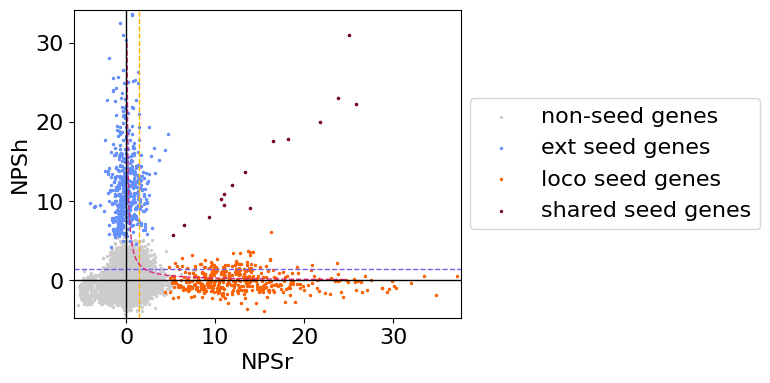

In [75]:
plt.figure(figsize=(5, 4))
plt.scatter(x=tbl_z['NPS_r'], y=tbl_z['NPS_h'], s=2, color=colour_dict['other'],label='non-seed genes')
#plt.scatter(x=inNetwork['NPS_r'], y=inNetwork['NPS_h'], s=1, color=colour_dict['shared'],label='network genes')
#plt.scatter(x=hm_only['NPS_r'], y=hm_only['NPS_h'], s=1, color=colour_dict['ext'],label='ext network genes')
#plt.scatter(x=rat_only['NPS_r'], y=rat_only['NPS_h'], s=1, color=colour_dict['loco'],label='loco network genes')
plt.scatter(x=seeds_h['NPS_r'], y=seeds_h['NPS_h'], s=2, color=colour_dict['ext_alt'],label='ext seed genes')
plt.scatter(x=seeds_r['NPS_r'], y=seeds_r['NPS_h'], s=2, color=colour_dict['loco_alt'],label='loco seed genes')
plt.scatter(x=seeds_hr['NPS_r'], y=seeds_hr['NPS_h'], s=2, color=colour_dict['shared_alt'],label='shared seed genes')


# Set labels and lines for plt
plt.xlabel('NPSr')
plt.ylabel('NPSh')
plt.axvline(x=1.5, color=colour_dict['loco'], linestyle='dashed', linewidth=1)
plt.axhline(y=1.5, color=colour_dict['ext'], linestyle='dashed', linewidth=1)

#plt.axvline(x=3, color=colour_dict['loco'], linestyle='dashed', linewidth=1)
#plt.axhline(y=3, color=colour_dict['ext'], linestyle='dashed', linewidth=1)
#plt.set_aspect('equal', 'box')

x_points = [(i + 0.0001) / 10 for i in range(-50, 250)]
combo_line = [3 / x for x in x_points if x > 3 / 50]
plt.plot([x for x in x_points if x > 3 / 40], combo_line, color=colour_dict['shared'], linestyle='dashed', linewidth=1)
plt.axvline(x=0, color='black', linestyle='solid', linewidth=1)
plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
plt.xlim([min(tbl_z['NPS_r'])-.5, max(tbl_z['NPS_r'])+.5])
plt.ylim([min(tbl_z['NPS_h'])-.5, max(tbl_z['NPS_h'])+.5])
plt.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))
if save_fig:
    plt.savefig('figures/scatter_seedgene_dist_'+label_r+'_'+label_h+'.svg',bbox_inches='tight')


In [57]:
save_fig=True

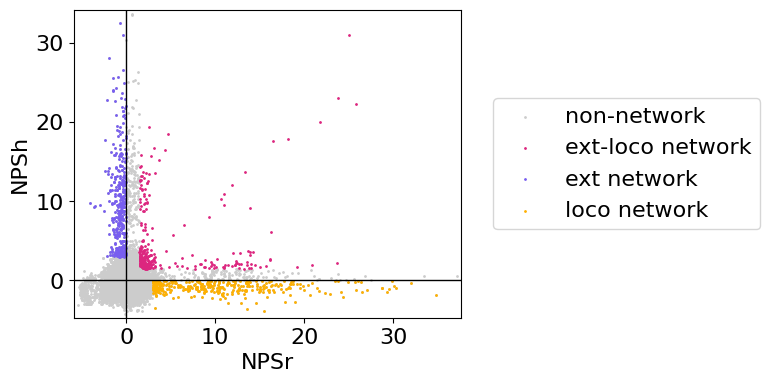

In [78]:
plt.figure(figsize=(5, 4))

plt.scatter(x=outNetwork['NPS_r'], y=outNetwork['NPS_h'], s=1, color=colour_dict['other'],label='non-network')
plt.scatter(x=inNetwork['NPS_r'], y=inNetwork['NPS_h'], s=1, color=colour_dict['shared'],label='ext-loco network')
plt.scatter(x=hm_only['NPS_r'], y=hm_only['NPS_h'], s=1, color=colour_dict['ext'],label='ext network')
plt.scatter(x=rat_only['NPS_r'], y=rat_only['NPS_h'], s=1, color=colour_dict['loco'],label='loco network')
#plt.scatter(x=seeds_h['NPS_r'], y=seeds_h['NPS_h'], s=1, color=colour_dict['ext_alt'],label='ext seed genes')
#plt.scatter(x=seeds_r['NPS_r'], y=seeds_r['NPS_h'], s=1, color=colour_dict['loco_alt'],label='loco seed genes')
#plt.scatter(x=seeds_hr['NPS_r'], y=seeds_hr['NPS_h'], s=1, color=colour_dict['shared_alt'],label='shared seed genes')


# Set labels and lines for plt
plt.xlabel('NPSr')
plt.ylabel('NPSh')
#plt.axvline(x=1.5, color=colour_dict['loco'], linestyle='dashed', linewidth=1)
#plt.axvline(x=3, color=colour_dict['loco'], linestyle='dashed', linewidth=1)
#plt.axhline(y=1.5, color=colour_dict['ext'], linestyle='dashed', linewidth=1)
#plt.axhline(y=3, color=colour_dict['ext'], linestyle='dashed', linewidth=1)
#x_points = [(i + 0.0001) / 10 for i in range(-50, 250)]
#combo_line = [3 / x for x in x_points if x > 3 / 50]
#plt.plot([x for x in x_points if x > 3 / 40], combo_line, color=colour_dict['shared'], linestyle='dashed', linewidth=1)

plt.axvline(x=0, color='black', linestyle='solid', linewidth=1)
plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
plt.xlim([min(tbl_z['NPS_r'])-.5, max(tbl_z['NPS_r'])+.5])
plt.ylim([min(tbl_z['NPS_h'])-.5, max(tbl_z['NPS_h'])+.5])
plt.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))
if save_fig:
    plt.savefig('figures/scatter_species_networks_dist'+label_r+'_'+label_h+'.svg',bbox_inches='tight')

In [75]:
# supplemental figure 5 of BMI paper
test_data = tbl_z.copy()
combo_thresholds = [i/20 for i in range(0, 101)]
sizes = {}
for tau in combo_thresholds:
    rat_th = {"rat":3, "human":0, "combo":-1 * tau}
    human_th = {"rat":0, "human":3, "combo":-1 * tau}
    conserved = {"rat":1.5, "human":1.5, "combo": tau}
    test_data = sub_graph(test_data, rat_th, human_th, conserved)
    sizes[tau] = test_data.value_counts("subgraph", dropna=False)
size_df = pd.DataFrame.from_dict(sizes).T

In [76]:
size_df.describe()

subgraph,PCNet,Human-Specific,Rat-Specific,Conserved
count,101.000000,101.000000,101.000000,101.000000
mean,18258.237624,364.326733,354.930693,289.504950
std,58.099251,6.652983,8.192994,44.156681
min,18214.000000,342.000000,332.000000,196.000000
25%,18214.000000,364.000000,355.000000,251.000000
50%,18220.000000,368.000000,360.000000,319.000000
75%,18297.000000,368.000000,360.000000,325.000000
max,18397.000000,368.000000,360.000000,325.000000


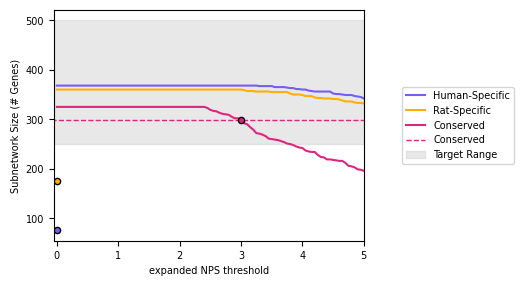

In [77]:
#plt.plot(size_df.index, size_df.Conserved, color=colour_dict["shared"], label="Conserved")
_, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(4,3)) #gridspec_kw ={'hspace':0.05})
plt.sca(ax1)
plt.plot(size_df.index, size_df["Human-Specific"], color=colour_dict["ext"], label="Human-Specific", zorder=2)
plt.plot(size_df.index, size_df['Rat-Specific'], color=colour_dict["loco"], label="Rat-Specific", zorder=2)
plt.plot(size_df.index, size_df['Conserved'], color=colour_dict["shared"], label="Conserved", zorder=2)
ax1.scatter(x=[3], y=[len(inNetwork)], s=20, zorder=5, color=colour_dict["shared"], edgecolor="black")
ax1.scatter(x=[0], y=[len(rat_only)], s=20, zorder=5, color=colour_dict["loco"], edgecolor="black")
ax1.scatter(x=[0], y=[len(hm_only)], s=20, zorder=5, color=colour_dict["ext"], edgecolor="black")
#ax1.scatter(x=[4], y=[800], s=20, zorder=0, color="white", edgecolor="black", label="Selected Threshold")
plt.ylabel("Subnetwork Size (# Genes)", fontsize=7)
plt.xlabel('expanded NPS threshold', fontsize=7)
plt.hlines(y=len(inNetwork), xmin=-0.1, xmax=5, color=colour_dict["shared"], linestyle="--", linewidth=1, label="Conserved")
ax1.fill_between([-0.05, 5], 500, 250, color="lightgrey", label="Target Range", zorder=1,alpha=0.5)
#plt.hlines(y=[300, 250], xmin=0, xmax=5, color="black", linestyle="--", linewidth=1, label="Target Range")
plt.xlim(-0.05, 5)
ax1.tick_params(labelsize=7)
plt.legend(fontsize=7, frameon=True,loc='center right', bbox_to_anchor=(1.5, 0.5))

#plt.savefig(FIGDIR + "Sup5d_threshold_network_structure.png", dpi=600, bbox_inches="tight")

# export networks

## human only

In [64]:
net=graph.subgraph(list(hm_only.index))
net2=format_network(net, label_r, label_h, seed_r , seed_h, NPS_r['z'], NPS_h['z'])

In [65]:
if save_fig:
    print('exporting network to NDEx')
    export_network(network=net, name=(label_r+'_'+label_h+'_'+interactome_name+'_hm_only'+'_MAGMA'), user=ndex_user, password=ndex_password)

exporting network to NDEx
bsleger
supnu8-muqsov-hobpUb
Generating CX


## rat only

In [66]:
net=graph.subgraph(list(rat_only.index))
net2=format_network(net, label_r, label_h, seed_r , seed_h, NPS_r['z'], NPS_h['z'])

In [67]:
if save_fig:
    print('exporting network to NDEx')
    export_network(network=net, name=(label_r+'_'+label_h+'_'+interactome_name+'_rat_only'+'_MAGMA'), user=ndex_user, password=ndex_password)

exporting network to NDEx
bsleger
supnu8-muqsov-hobpUb
Generating CX


# compare the NPS scores for different cutoffs of seed genes

In [56]:
NPS_dict.keys()

dict_keys(['loco_gsem_FDR_PCNet2.0', 'loco_gsem_FDR_PCNet2.1', 'loco_gsem_FDR_PCNet2.2', 'loco_gsem_bonf_PCNet2.0', 'loco_gsem_bonf_PCNet2.1', 'loco_gsem_bonf_PCNet2.2', 'ext_FDR_PCNet2.0', 'ext_FDR_PCNet2.2', 'ext_bonf_PCNet2.0', 'ext_bonf_PCNet2.2', 'ext_top500_PCNet2.0', 'ext_subsample_PCNet2.0'])

Text(0.5, 1.0, 'Externalizing NPSh bonf vs. subsample')

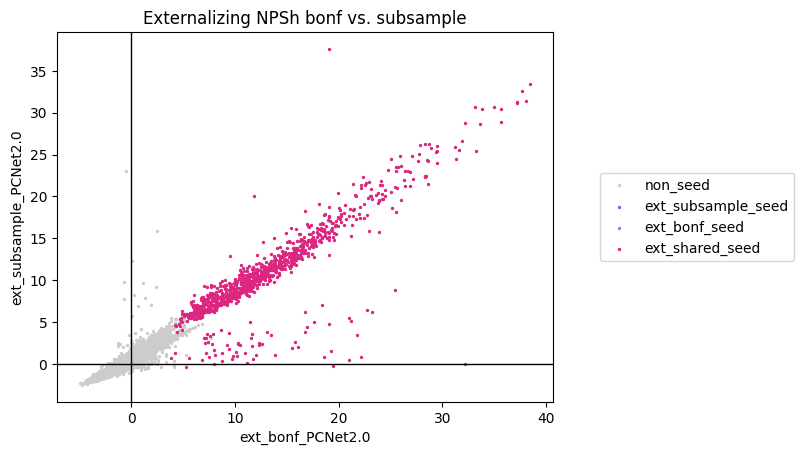

In [58]:
cutx='bonf'
cuty='subsample'
x_lab=trait_h+'_'+cutx+'_'+interactome_name
y_lab=trait_h+'_'+cuty+'_'+interactome_name


plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['other'],label='non_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext'],label='ext_'+cuty+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext_alt'],label='ext_'+cutx+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['shared'],label='ext_shared_seed',s=2)

plt.axvline(x=0, color='black', linestyle='solid', linewidth=1)
plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
plt.xlabel(x_lab)
plt.ylabel(y_lab)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.title('Externalizing NPSh '+cutx+' vs. '+cuty)

Text(0.5, 1.0, 'Externalizing NPSh bonf vs. top500')

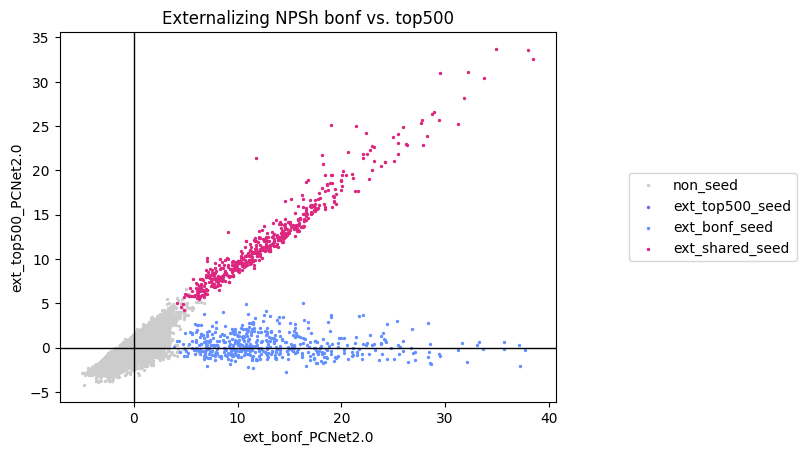

In [59]:
cutx='bonf'
cuty='top500'
x_lab=trait_h+'_'+cutx+'_'+interactome_name
y_lab=trait_h+'_'+cuty+'_'+interactome_name


plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['other'],label='non_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext'],label='ext_'+cuty+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext_alt'],label='ext_'+cutx+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['shared'],label='ext_shared_seed',s=2)

plt.axvline(x=0, color='black', linestyle='solid', linewidth=1)
plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
plt.xlabel(x_lab)
plt.ylabel(y_lab)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.title('Externalizing NPSh '+cutx+' vs. '+cuty)

Text(0.5, 1.0, 'Externalizing NPSh top500 vs. subsample')

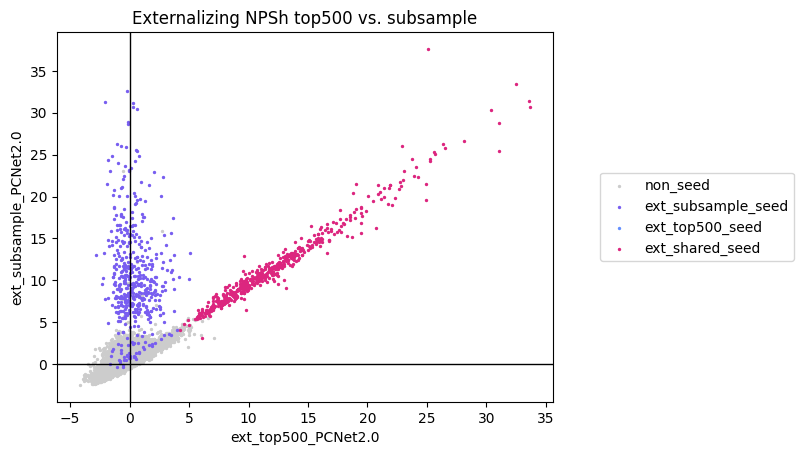

In [60]:
cutx='top500'
cuty='subsample'
x_lab=trait_h+'_'+cutx+'_'+interactome_name
y_lab=trait_h+'_'+cuty+'_'+interactome_name


plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['other'],label='non_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext'],label='ext_'+cuty+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext_alt'],label='ext_'+cutx+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['shared'],label='ext_shared_seed',s=2)

plt.axvline(x=0, color='black', linestyle='solid', linewidth=1)
plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
plt.xlabel(x_lab)
plt.ylabel(y_lab)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.title('Externalizing NPSh '+cutx+' vs. '+cuty)

Text(0.5, 1.0, 'Externalizing NPSh bonf vs. FDR')

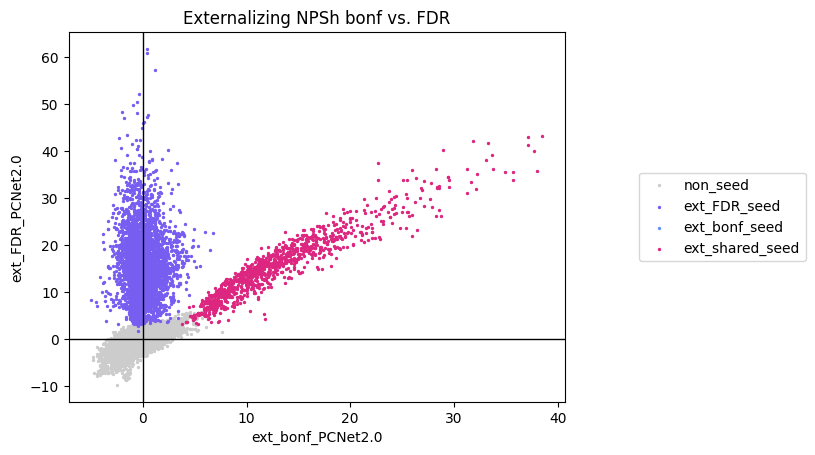

In [61]:
cutx='bonf'
cuty='FDR'
x_lab=trait_h+'_'+cutx+'_'+interactome_name
y_lab=trait_h+'_'+cuty+'_'+interactome_name


plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['other'],label='non_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext'],label='ext_'+cuty+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext_alt'],label='ext_'+cutx+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['shared'],label='ext_shared_seed',s=2)

plt.axvline(x=0, color='black', linestyle='solid', linewidth=1)
plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
plt.xlabel(x_lab)
plt.ylabel(y_lab)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.title('Externalizing NPSh '+cutx+' vs. '+cuty)